📂 1. Import Libraries

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import matplotlib.pyplot as plt
import pickle


📂 2. Load Data

In [4]:
# Define file path
file_path = "zincphosph1.xlsx"  # Change this path if needed

# Read all sheets from Excel file
xls = pd.ExcelFile(file_path)
sheet_names = xls.sheet_names

# Concatenate all sheets into one DataFrame
dfs = [pd.read_excel(xls, sheet_name=sheet) for sheet in sheet_names]
df_full = pd.concat(dfs, axis=1)

print("Data loaded successfully. Shape:", df_full.shape)
df_full.head()


Data loaded successfully. Shape: (66, 78)


,No,poison severity score,NE_given (Norepinephrine),NaHCO3_given (Sodium Bicarbonate),Age (in years),"Sex (1=Male, 2=Female)","Time_since_exposure (1=0.5-1h, 2=1-3h, 3=>3h)","Exposure_condition (1=Newly opened, 2=Exposed to moisture)","Delivery_method (1=Ingested directly, 2=Dissolved in water, 3=On food)",Dose_taken (in sachets),...,NLR_interpret,Platelets (x10^3),PLR (Platelet-to-Lymph Ratio),PLR_interpret,"Survival (1=Survived, 0=Died)",Hospital_stay_days,Ventilation_days,ICU_stay_days,"Need_vasopressors (1=Yes, 0=No)",NE_total_dose_at_discharge
0,1,1,0,0,29.0,1,1,1,2,1.00,...,3,287,134.230,1,1,2,0,0,0,0
1,2,1,0,0,18.0,2,1,1,2,1.00,...,1,267,117.828,1,1,2,0,0,0,0
2,3,1,0,0,19.0,1,3,1,1,1.00,...,1,289,129.420,1,1,3,0,0,0,0
3,4,1,0,0,21.0,2,2,1,1,1.00,...,1,281,104.400,1,1,2,0,0,0,0
4,5,1,0,0,15.0,2,2,1,1,0.25,...,1,300,127.060,1,1,3,0,0,0,0


🧹 3. Data Preparation

In [5]:
# Define target column
target_col = "Survival (1=Survived, 0=Died) "

# Split features and target
y = df_full[target_col]
X = df_full.drop(columns=[target_col])

# Remove duplicate columns if any
X = X.loc[:, ~X.columns.duplicated()]

# Fill missing values with placeholder
X = X.fillna(-999)

print("Data prepared. Features shape:", X.shape)


Data prepared. Features shape: (66, 77)


🔄 4. Encode Categorical Features

In [6]:
X_encoded = X.copy()

# Encode categorical (object) columns
for col in X_encoded.columns:
    if X_encoded[col].dtype == 'object':
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))

print("Categorical features encoded.")


Categorical features encoded.


🧪 5. Balance Classes with Upsampling

In [7]:
# Combine features and target
df_model = X_encoded.copy()
df_model['Survival'] = y.values

# Separate majority and minority classes
df_survived = df_model[df_model['Survival'] == 1]
df_died = df_model[df_model['Survival'] == 0]

# Upsample minority class
df_died_upsampled = resample(
    df_died,
    replace=True,
    n_samples=len(df_survived),  # Match the majority class
    random_state=42
)

# Combine into balanced dataset
df_balanced = pd.concat([df_survived, df_died_upsampled])

X_balanced = df_balanced.drop(columns=['Survival'])
y_balanced = df_balanced['Survival']

print("Dataset balanced. New class distribution:")
print(y_balanced.value_counts())


Dataset balanced. New class distribution:
Survival
1    65
0    65
Name: count, dtype: int64


✂️ 6. Train/Test Split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42
)

print(f"Data split: Train = {X_train.shape}, Test = {X_test.shape}")


Data split: Train = (104, 77), Test = (26, 77)


🌳 7. Train the Random Forest Model

In [9]:
# Initialize and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

print("Model training completed.")


Model training completed.


📊 8. Evaluate the Model

In [10]:
# Make predictions
y_pred = model.predict(X_test)

# Generate classification report
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

print("Classification Report:")
report_df


Classification Report:


,precision,recall,f1-score,support
0,1.0,1.0,1.0,12.0
1,1.0,1.0,1.0,14.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,26.0
weighted avg,1.0,1.0,1.0,26.0


💾 9. Save Classification Report

In [11]:
report_df.to_csv("classification_report.csv")
print("Classification report saved to 'classification_report.csv'")


Classification report saved to 'classification_report.csv'


🔍 10. Feature Importance

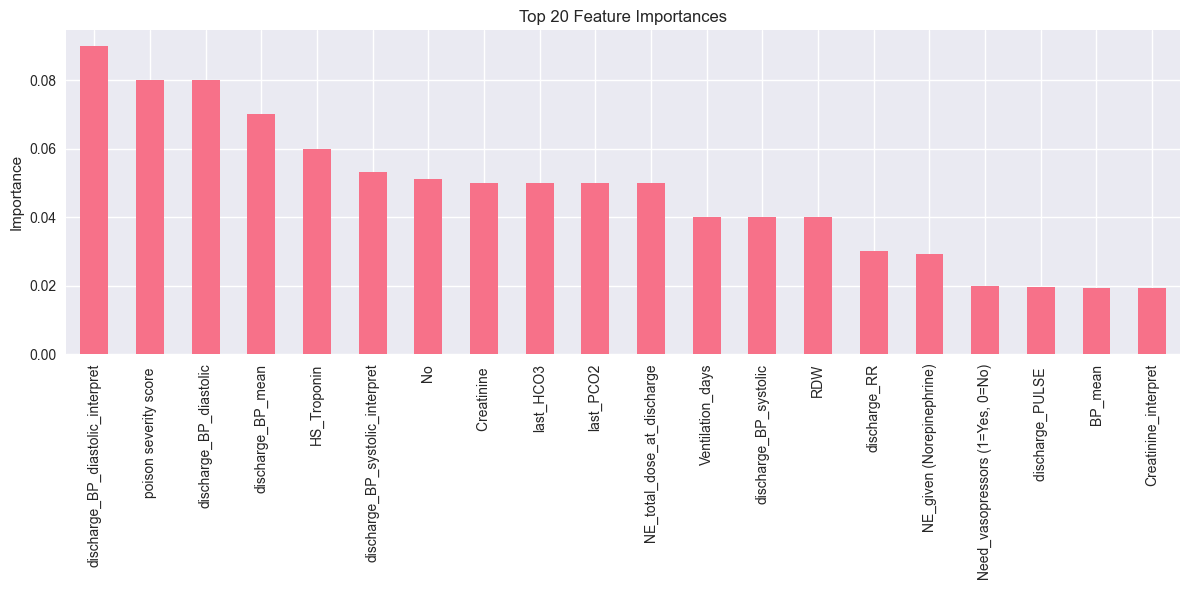

Feature importance plot saved to 'feature_importance.png'


In [12]:
importances = model.feature_importances_
feat_importance = pd.Series(importances, index=X_balanced.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
feat_importance.head(20).plot(kind='bar')
plt.title("Top 20 Feature Importances")
plt.ylabel("Importance")
plt.tight_layout()
plt.savefig("feature_importance.png")
plt.show()

print("Feature importance plot saved to 'feature_importance.png'")


💾 11. Save Trained Model

In [13]:
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)

print("Trained model saved to 'model.pkl'")


Trained model saved to 'model.pkl'
